In [374]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [375]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
EPOCHS=50


In [376]:
dataSet = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [377]:
class_names = dataSet.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

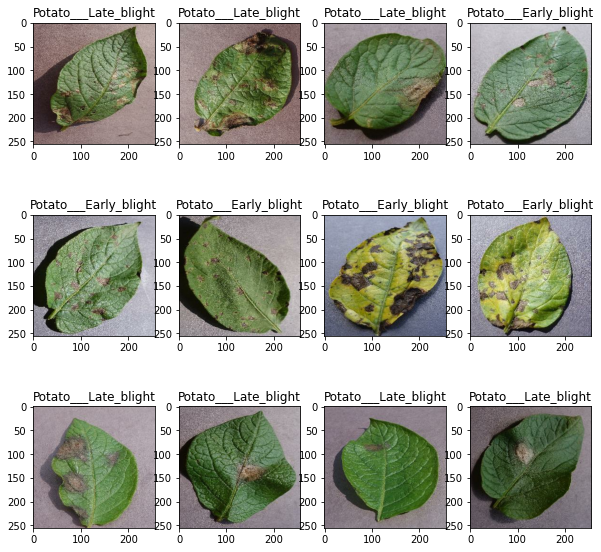

In [378]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataSet.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])

# Train

In [379]:
# we do 80,20 split test
# train_test_split = len(dataSet)*TRAIN_SIZE
# train_test_split
# train_ds = dataSet.take(int(train_test_split))
# len(train_ds)

In [380]:
# test_ds = dataSet.skip(int(train_test_split))
# # dividing into 10 validation, 10 testing
# val_value = len(dataSet)*VAL_SIZE
# val_ds = dataSet.take(int(val_value))
# test_ds = dataSet.skip(int(val_value))

# Creating Function train, split, validation

In [381]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_len = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(ds_len*train_split)
    val_size = int(ds_len*val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [382]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataSet)

In [383]:
len(test_ds)

8

# Creating a faster proccess for the batch to train

In [384]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [385]:
# in this proccess will allows all the image that comes in stays at IMAGE_SIZE
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [386]:
# data augmentation for the model to predict difference image
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [458]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size = (3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [459]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_27 (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_28 (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_89 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_91 (Conv2D)           (32, 60, 60, 64)        

In [460]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [461]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 3s 43ms/step - loss: 0.8786 - accuracy: 0.5451 - val_loss: 0.7610 - val_accuracy: 0.6198
Epoch 2/50
54/54 [==============================] - 2s 42ms/step - loss: 0.6215 - accuracy: 0.7274 - val_loss: 0.5148 - val_accuracy: 0.7552
Epoch 3/50
54/54 [==============================] - 2s 43ms/step - loss: 0.3709 - accuracy: 0.8403 - val_loss: 0.3611 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 2s 43ms/step - loss: 0.2767 - accuracy: 0.8860 - val_loss: 0.2853 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 2s 42ms/step - loss: 0.3683 - accuracy: 0.8426 - val_loss: 0.3124 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 2s 42ms/step - loss: 0.2184 - accuracy: 0.9103 - val_loss: 0.1808 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 2s 41ms/step - loss: 0.1975 - accuracy: 0.9201 - val_loss: 0.1806 - val_accuracy: 0.9115
Epoch 8/50
54

In [462]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 0s 14ms/step - loss: 0.1039 - accuracy: 0.9648


[0.10389750450849533, 0.96484375]

In [463]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [464]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

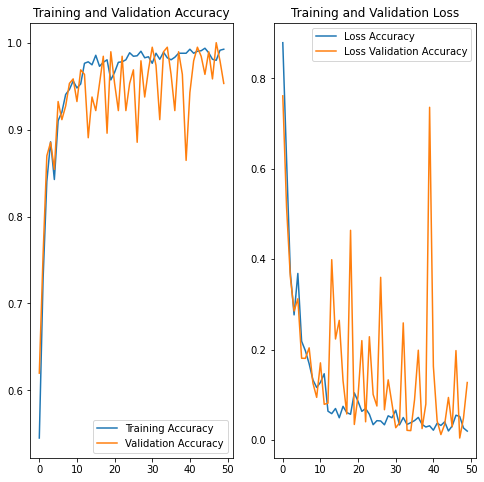

In [465]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc, label='Training Accuracy')
plt.plot(range(50),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Loss Accuracy')
plt.plot(range(EPOCHS),val_loss, label='Loss Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


the first image to predict
First image's actual label :  Potato___Late_blight
predicted label: Potato___Late_blight


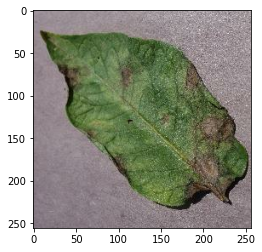

In [454]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("the first image to predict")
    plt.imshow(first_image)
    print("First image's actual label : ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Create prediction function

In [466]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

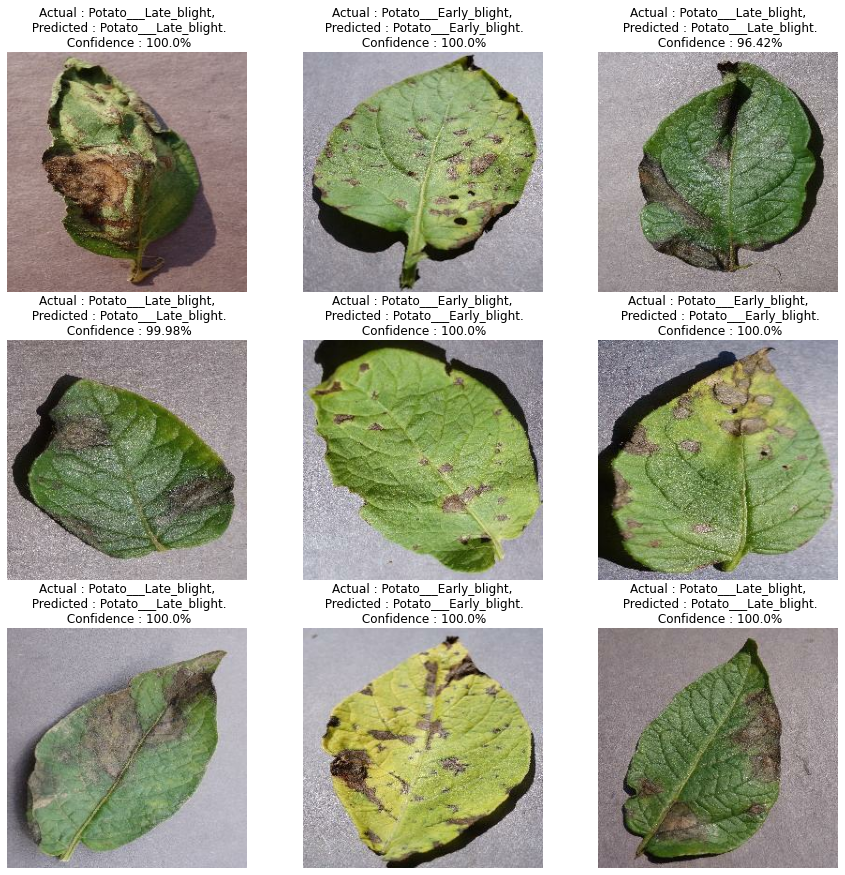

In [471]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3 , i+1 )
        plt.imshow(images[i].numpy().astype('uint8'))
        
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}.\n Confidence : {confidence}%")
        
        plt.axis("off")

# Saving Model

In [474]:
# saving model
import os
model_version = max([int(i) for i in os.listdir("./models")+[0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets
